In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=20):
    """
    改进：识别高频交易冲击模式，捕捉市场微观结构变化
    金融意义：检测程序化交易导致的盘口异常行为
    """
    df = df.copy()
    # 计算高频冲击指标
    df['mid_price'] = (df['high'] + df['low']) / 2
    df['price_slope'] = df['mid_price'].diff() / df['volume'].replace(0, 1)
    df['impact'] = np.where(df['price_slope'].abs() > df['price_slope'].rolling(50).mean() * 2, 
                           np.sign(df['price_slope']), 0)
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 冲击方向分类
        buy_impact_mask = group['impact'] > 0
        sell_impact_mask = group['impact'] < 0
        
        # 买方冲击重心
        if buy_impact_mask.any():
            buy_weights = group.loc[buy_impact_mask, 'volume']
            G_buy = np.sum(time_idx[buy_impact_mask] * buy_weights) / buy_weights.sum()
        else:
            G_buy = np.nan
            
        # 卖方冲击重心
        if sell_impact_mask.any():
            sell_weights = group.loc[sell_impact_mask, 'volume']
            G_sell = np.sum(time_idx[sell_impact_mask] * sell_weights) / sell_weights.sum()
        else:
            G_sell = np.nan
            
        daily_results.append({
            'date': date,
            'G_buy': G_buy,
            'G_sell': G_sell,
            'impact_ratio': buy_impact_mask.mean() / (sell_impact_mask.mean() + 1e-10)
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 冲击重心偏离模型
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 冲击比例作为特征
        X = train_data[['G_buy', 'impact_ratio']].values
        y = train_data['G_sell'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_buy']) or pd.isna(current['G_sell']):
            residuals.append(np.nan)
        else:
            pred_G_sell = model.predict([[current['G_buy'], current['impact_ratio']]])[0]
            residuals.append(current['G_sell'] - pred_G_sell)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 冲击强度调整
    impact_strength = daily_df['impact_ratio'].diff().abs().rolling(3).mean()
    daily_df['factor'] = daily_df['residual'].rolling(window).mean() * impact_strength
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.022266
   Rank_IC (Spearman): 0.024398
📊 信息比率:
   IR: 0.448465
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


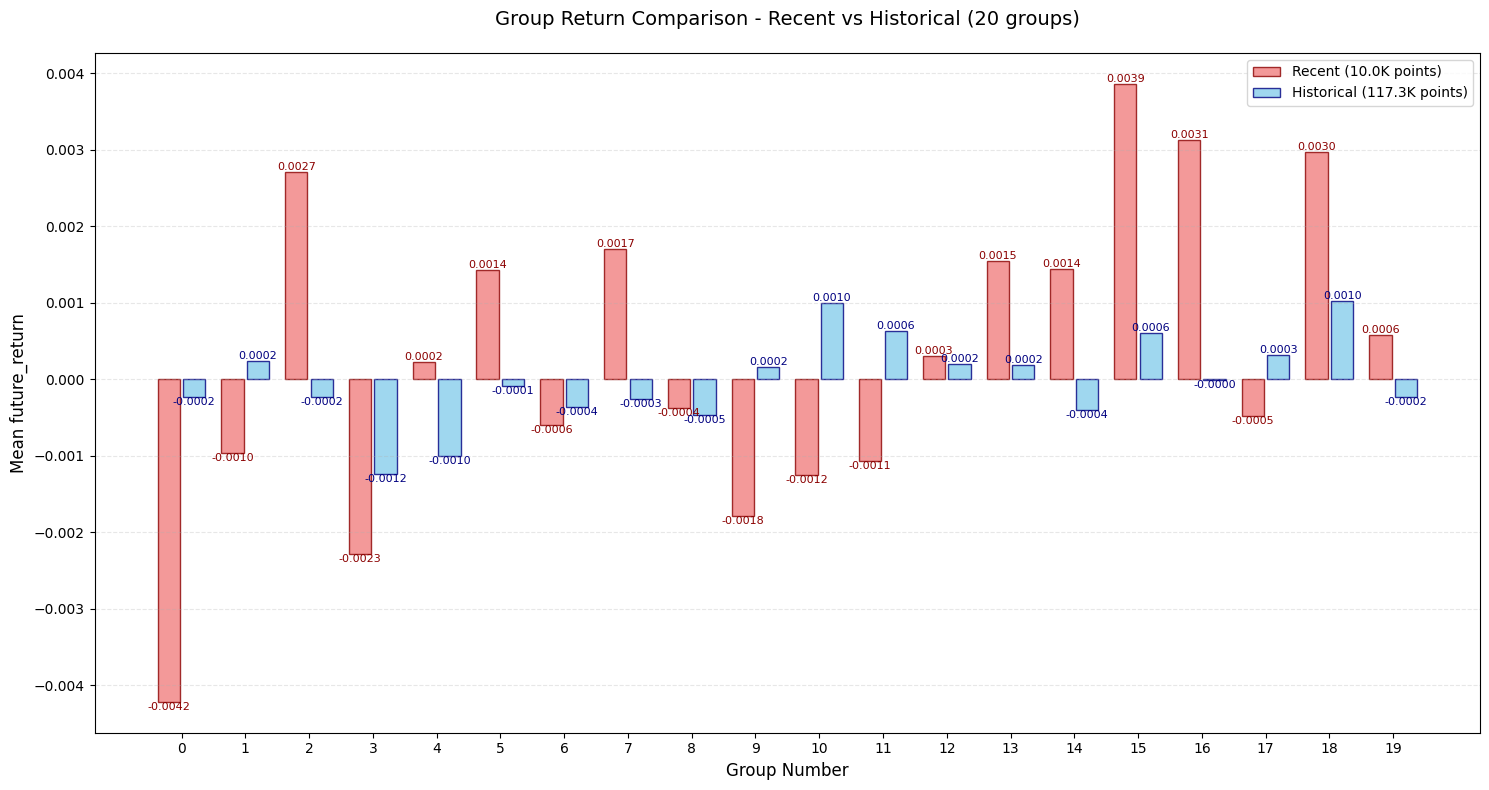

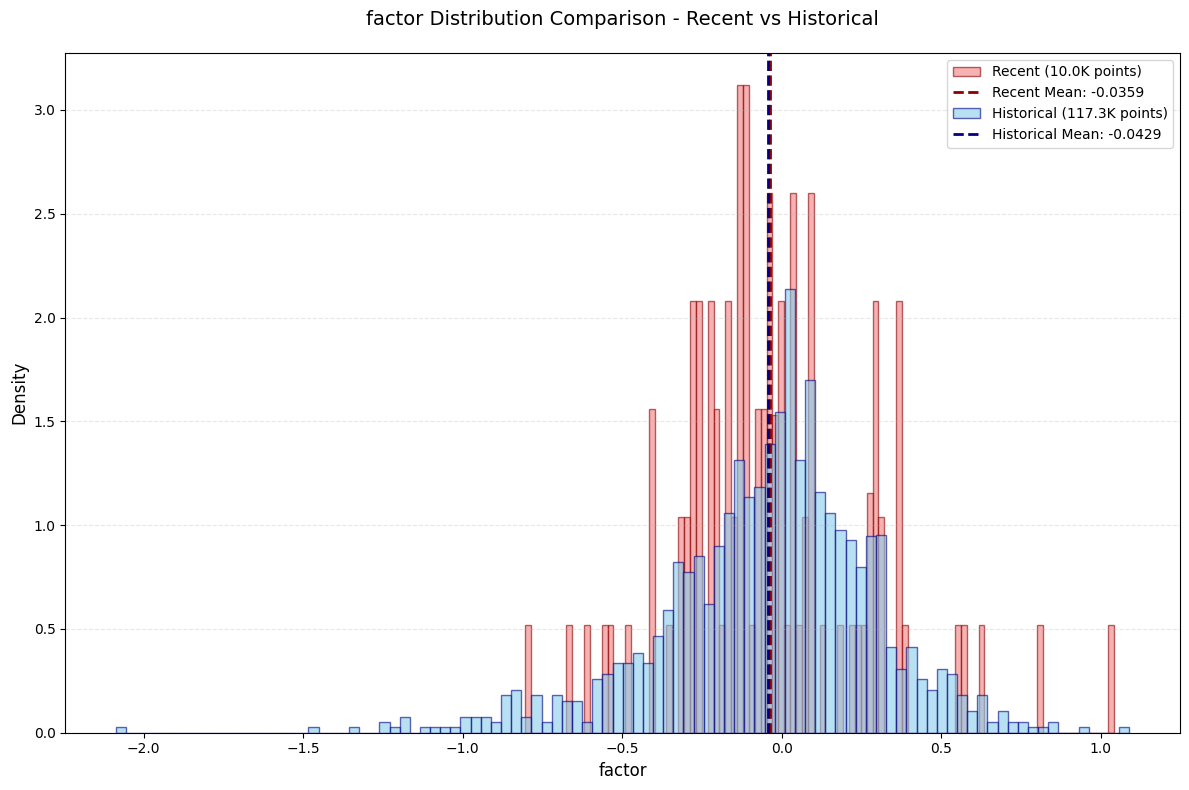

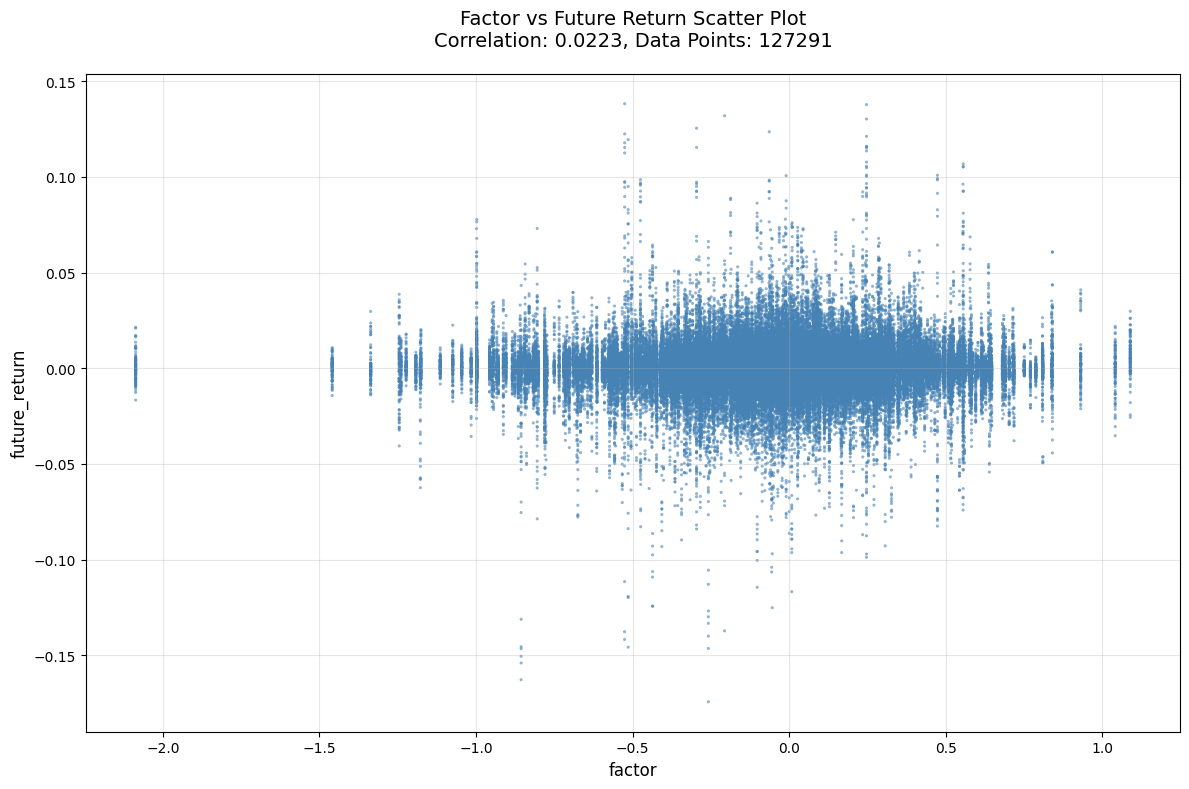

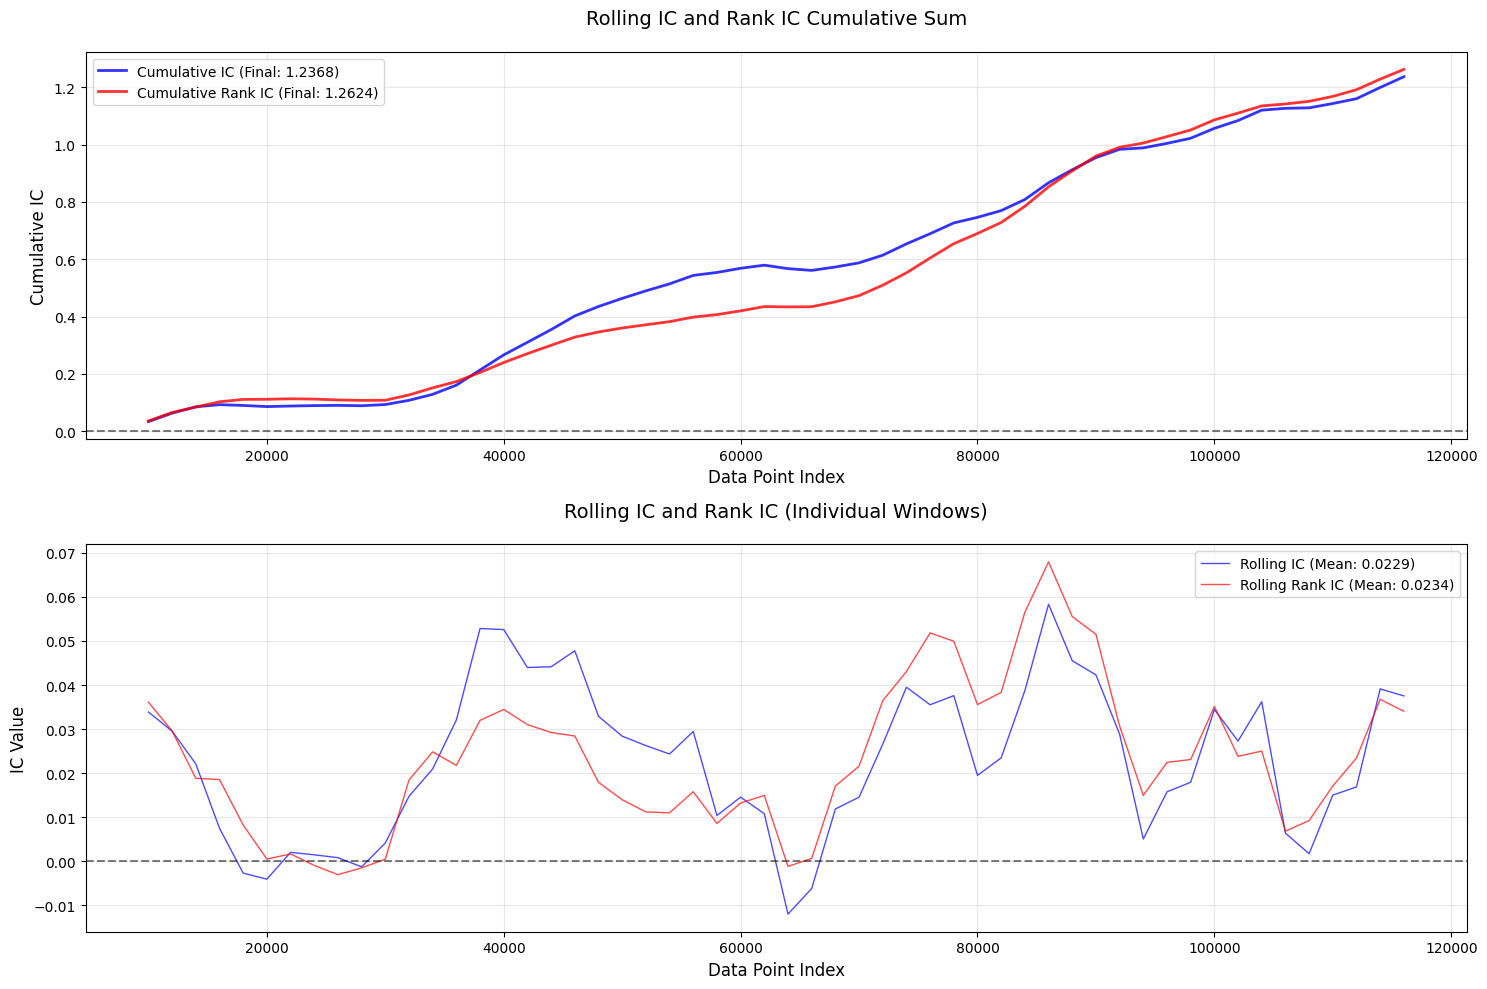

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.010839259892752728,
 -0.03409473691989445,
 0.0377492466582324,
 0.006868698388161525,
 0.03323965276100867,
 0.0016462761340237434,
 0.01662445249189629,
 0.07029112341296456,
 0.02197688639541925,
 -0.015384767268795896]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.022266139542211752, 'Rank_IC': 0.024397613801120634}, 'information_ratio': {'IR': 0.44846527100347744, 'group_correlations': [-0.010839259892752728, -0.03409473691989445, 0.0377492466582324, 0.006868698388161525, 0.03323965276100867, 0.0016462761340237434, 0.01662445249189629, 0.07029112341296456, 0.02197688639541925, -0.015384767268795896], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -2.0871  -0.6552   -0.8948      -0.0004      0.0124   6432
1      -0.6532  -0.4469   -0.5312       0.0000      0.0140   6336
2      -0.4468  -0.3362   -0.3872      -0.0004      0.0124   6336
3      -0.3357  -0.2766   -0.3071      -0.0011      0.0128   6432
4      -0.2764  -0.2144   -0.2478      -0.0009      0.0118   6336
5      -0.2142  -0.1641   -0.1866      -0.0000      0.0108   6336
6      -0.1637  -0.1247   -0.1429      -0.0